In [1]:
import sys
sys.path.append("../../../")

In [2]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from model.losses import *
from model.bpho.multi import *
from model.bpho.resnet import *
from model.bpho.unet import *
from model.metrics import psnr, ssim
from data.load_fluo import *

In [3]:
torch.cuda.set_device(2)

# Model loading

### load data

In [4]:
bs = 8  # batch size
size = 800  # image size
tile_sz=512 
lr_type = 't'
data_pth = Path('/home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/training/trainsets/')
model_pth = Path('/home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/models/feat_loss')
if lr_type == 's':
    z_frames, t_frames = 1, 1
    n_frames = 1
    dataset = data_pth/'mitotracker_PSSR-SF'
    hr_tifs = dataset/f'hr'
    lr_tifs = dataset/f'lr'
elif lr_type == 't':
    z_frames, t_frames = 1, 5
    n_frames = 5
    multi_str = f'_{lr_type}_{n_frames}'
    tile_sz = 512
    dataset = data_pth/'mitotracker_PSSR-MF'
    hr_tifs = dataset/f'hr_t_{tile_sz:d}{multi_str}'
    lr_tifs = dataset/f'lr_t_{tile_sz:d}{multi_str}'

In [5]:
mode = 'L'
norm = True
noise = False
cutout = False # Maybe?

In [6]:
data = get_data(bs, size, lr_tifs, hr_tifs, n_frames=n_frames,  max_zoom=4., 
                    use_cutout=cutout, use_noise=noise, mode=mode, norm=norm)

normalizing x and y data


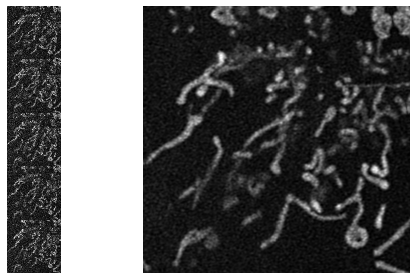

In [7]:
data.show_batch(rows=1, cmap='gray')

In [8]:
xb, yb = data.one_batch()

In [19]:
yb.max()

tensor(0.9992)

In [20]:
xb.max()

tensor(0.9847)

In [14]:
data_n = get_data(bs, size, lr_tifs, hr_tifs, n_frames=n_frames,  max_zoom=4., 
                    use_cutout=cutout, use_noise=noise, mode=mode, norm=False)

In [16]:
xb_n, yb_n = data_n.one_batch()

In [17]:
xb_n.min()

tensor(0.)

In [18]:
yb_n.min()

tensor(0.)

### initiate learner

In [9]:
wnres_args = {
    'blur': True,
    'blur_final': True,
    'bottle': True,
    'self_attention': True,
    'last_cross': True
    
}
arch = 'wnresnet34'
wd = 1e-3
arch = eval(arch)
metrics = [psnr, ssim]

In [10]:
learn = wnres_unet_learner(data, arch, in_c=n_frames, wnres_args=wnres_args,
                         metrics=metrics,
                           model_dir=model_pth, callback_fns=[LossMetrics], wd=wd)

In [10]:
learn.model_dir

PosixPath('/home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/models/feat_loss')

In [29]:
learn.data

MultiImageDataBunch;

Train: LabelList (5000 items)
x: MultiImageImageList
MultiImage: ['Image (1, 192, 192)', 'Image (1, 192, 192)', 'Image (1, 192, 192)', 'Image (1, 192, 192)', 'Image (1, 192, 192)'],MultiImage: ['Image (1, 192, 192)', 'Image (1, 192, 192)', 'Image (1, 192, 192)', 'Image (1, 192, 192)', 'Image (1, 192, 192)'],MultiImage: ['Image (1, 192, 192)', 'Image (1, 192, 192)', 'Image (1, 192, 192)', 'Image (1, 192, 192)', 'Image (1, 192, 192)'],MultiImage: ['Image (1, 192, 192)', 'Image (1, 192, 192)', 'Image (1, 192, 192)', 'Image (1, 192, 192)', 'Image (1, 192, 192)'],MultiImage: ['Image (1, 192, 192)', 'Image (1, 192, 192)', 'Image (1, 192, 192)', 'Image (1, 192, 192)', 'Image (1, 192, 192)']
y: ImageList
Image (1, 768, 768),Image (1, 768, 768),Image (1, 768, 768),Image (1, 768, 768),Image (1, 768, 768)
Path: /home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/training/trainsets/mitotracker_PSSR-MF/lr_t_512_t_5;

Valid: LabelList (200 items)
x: MultiImageImageList
MultiImage: ['

# load testing data

In [ ]:
import shutil
from skimage.filters import gaussian
from skimage.io import imsave
import PIL
import imageio
from scipy.ndimage.interpolation import zoom as npzoom
import czifile
import PIL
import numpy as np
from fastprogress import progress_bar
from pathlib import Path
import torch
import math
from time import sleep
import shutil
from skimage.util import random_noise
from skimage import filters

def img_to_uint8(img, img_info=None):
    img = img.copy()
    if img_info and img_info['dtype'] != np.uint8:
        img -= img.min()
        img /= img.max()
        img *= np.iinfo(np.uint8).max
    return img.astype(np.uint8)

In [16]:
def tif_predict_movie(learn,
                      tif_in,
                      orig_out='orig.tif',
                      pred_out='pred.tif',
                      size=128,
                      wsize=3):
    im = PIL.Image.open(tif_in)
    im.load()
    times = im.n_frames
    #times = min(times,100)
    imgs = []

    if times < (wsize + 2):
        print(f'skip {tif_in} only {times} frames')
        return

    for i in range(times):
        im.seek(i)
        imgs.append(np.array(im).astype(np.float32) / 255.)
    img_data = np.stack(imgs)

    def pull_frame(i):
        im.seek(i)
        im.load()
        return np.array(im)

    preds = []
    origs = []
    img_max = img_data.max()

    x, y = im.size
    #print(f'tif: x:{x} y:{y} t:{times}')
    for t in progress_bar(list(range(0, times - wsize + 1))):
        img = img_data[t:(t + wsize)].copy()
        img /= img_max
        return img
        out_img = unet_multi_image_from_tiles(learn,
                                              img,
                                              tile_sz=size,
                                              wsize=wsize)
        pred = (out_img * 255).cpu().numpy().astype(np.uint8)
        preds.append(pred)
#         orig = (img[1][None] * 255).astype(np.uint8)
#         origs.append(orig)
    if len(preds) > 0:
        all_y = img_to_uint8(np.concatenate(preds))
        imageio.mimwrite(
            pred_out, all_y,
            bigtiff=True)  #, fps=30, macro_block_size=None) # for mp4
#         all_y = img_to_uint8(np.concatenate(origs))
#         imageio.mimwrite(orig_out, all_y,
#                          bigtiff=True)  #, fps=30, macro_block_size=None)

In [37]:
def unet_multi_image_from_tiles(learn, in_img, tile_sz=128, scale=4, wsize=3):
    cur_size = in_img.shape[1:3]
    c = in_img.shape[0]
    new_size = (cur_size[0] * scale, cur_size[1] * scale)
    w, h = cur_size
    
    # if scale=4, what's the size of the tile after scaling down
    in_tile = torch.zeros((c, tile_sz // scale, tile_sz // scale)) 
    # output img size
    out_img = torch.zeros((1, w * scale, h * scale))
    # tile_sz after scaling down
    tile_sz //= scale

    for x_tile in range(math.ceil(w / tile_sz)):
        for y_tile in range(math.ceil(h / tile_sz)):

            x_start = x_tile * tile_sz
            x_end = min(x_start + tile_sz, w)
            y_start = y_tile * tile_sz
            y_end = min(y_start + tile_sz, h)

            in_tile[:, 0:(x_end - x_start), 0:(y_end - y_start)] = tensor(
                in_img[:, x_start:x_end, y_start:y_end])
#             return npzoom(in_tile[0], scale, order=1)
            img_list = [
                Image(tensor(npzoom(in_tile[i], scale, order=1))[None])
                for i in range(wsize)
            ]

            tlist = MultiImage(img_list)
            out_tile, _, _ = learn.predict(tlist)

            out_x_start = x_start * scale
            out_x_end = x_end * scale
            out_y_start = y_start * scale
            out_y_end = y_end * scale

            #print("out: ", out_x_start, out_y_start, ",", out_x_end, out_y_end)
            in_x_start = 0
            in_y_start = 0
            in_x_end = (x_end - x_start) * scale
            in_y_end = (y_end - y_start) * scale
            #print("tile: ",in_x_start, in_y_start, ",", in_x_end, in_y_end)

            out_img[:, out_x_start:out_x_end, out_y_start:
                    out_y_end] = out_tile.data[:, in_x_start:in_x_end,
                                               in_y_start:in_y_end]
    return out_img

In [16]:
def get_pred_name(input_path, model_name):
    dir_name = Path(str(input_path.parent).replace('LR', 'MF_'+model_name))
    if not os.path.isdir(dir_name): dir_name.mkdir(parents=True, exist_ok=True)
    return dir_name/(input_path.stem+'_MF_'+model_name+'.tif')

In [21]:
def predict_folder(folder_path, learner, model_name):
    tif_list = list(folder_path.glob('*.tif'))
    for tif in progress_bar(tif_list):
        pred_name = get_pred_name(tif, model_name)
        tif_predict_movie(learner, tif, orig_out='original.tif', pred_out=pred_name, size=768, wsize=5)

In [11]:
test_pth = Path('/home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/testing/LR/real-world_mitotracker/')

In [14]:
tif_list = list(test_pth.glob('*.tif'))

In [21]:
img_input = tif_predict_movie(learn, tif_list[0], wsize=5)

In [23]:
img_input.shape[1:3]

(250, 250)

In [26]:
k = 800; k//=4;k

200

In [23]:
for model in progress_bar([
                    "fluo_inpainting_100epoch",
                   "fluo_inpainting_new_100epoch",
                   "fluo_sf_100epoch"
                    ]):
    learn = learn.load(file=model)
    predict_folder(test_pth, learn, model)
#     tif_predict_movie(learn, test_pth, orig_out='original.tif', pred_out=f'{model}.tif', size=800, wsize=5)

## npys

In [122]:
### Convert TIFF stacks to npy files for model inference
from libtiff import TIFF
img_size = 250
test_pth = Path('/home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/testing/test_datasources/NEW_non-moving_mitotracker')
test_files = sorted(list(test_pth.glob('*.tif')))
for tif_fname in test_files:
    tif = TIFF.open(tif_fname)
    img_stack = np.zeros((10, img_size, img_size), dtype=np.uint8)
    for i, img in enumerate(tif.iter_images()):
        img_stack[i] = img
    for i in range(6):
        five_stack = np.zeros((5, img_size, img_size), dtype=np.uint8)
        five_stack = img_stack[i:i+5]
        npy_fname = str(tif_fname)+f'_{i}.npy'
        np.save(npy_fname, five_stack)

In [87]:
five_stack

dtype('float64')

In [105]:
np.load(test_pth/'realworld_lowres_lowpower_4_LR.tif_5.npy', )

dtype('float64')

In [68]:
five_stack

array([[[0., 1., 1., 0., ..., 1., 0., 0., 0.],
        [2., 0., 1., 1., ..., 0., 0., 0., 0.],
        [4., 0., 0., 1., ..., 0., 0., 0., 0.],
        [0., 0., 0., 0., ..., 0., 0., 0., 1.],
        ...,
        [1., 1., 0., 0., ..., 1., 0., 0., 0.],
        [0., 0., 0., 1., ..., 0., 0., 0., 0.],
        [0., 0., 0., 0., ..., 0., 0., 0., 0.],
        [0., 0., 0., 0., ..., 0., 0., 0., 0.]],

       [[3., 0., 0., 0., ..., 0., 0., 0., 0.],
        [0., 0., 0., 0., ..., 0., 0., 0., 0.],
        [0., 3., 0., 0., ..., 0., 0., 1., 0.],
        [1., 1., 0., 0., ..., 0., 1., 0., 0.],
        ...,
        [0., 0., 0., 0., ..., 0., 0., 0., 0.],
        [0., 0., 0., 0., ..., 0., 1., 0., 0.],
        [0., 0., 0., 0., ..., 0., 0., 0., 0.],
        [0., 0., 0., 0., ..., 0., 0., 0., 2.]],

       [[2., 0., 0., 3., ..., 0., 0., 0., 0.],
        [0., 0., 0., 0., ..., 0., 3., 0., 1.],
        [0., 0., 0., 0., ..., 0., 0., 0., 3.],
        [0., 0., 0., 0., ..., 0., 0., 1., 0.],
        ...,
        [1., 0., 

In [61]:
five_stack.shape

(5, 250, 250)

In [22]:
img_pth = Path('/home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/training/trainsets/mitotracker_PSSR-MF/lr_t_512_t_5/valid/mitotracker')
img = np.load(img_pth/'mitotracker_PSSR-MF_valid_lr_001.npy')

In [23]:
img.shape

(5, 126, 126)